In [1]:
import pandas as pd # convert excel to dataframe
import numpy as np # convert dataframe to nparray for solver
from scipy.integrate import odeint # solve ode
from lmfit import minimize, Parameters, Parameter, report_fit # fitting
import matplotlib.pyplot as plt # plot data and results

In [2]:
data = './datasets/Stephan_pH7.xlsx'
df = pd.read_excel(data)
#print(df)

In [3]:
data_time = df[df.columns[0]].to_numpy(np.float64)
print(data_time)
data_s = df[df.columns[1]].to_numpy(np.float64)
print(data_s)

[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.         2.08333333 2.16666667 2.25       2.33333333 2.41666667
 2.5        2.58333333 2.66666667 2.75       2.83333333 2.91666667
 3.         3.08333333 3.16666667 3.25       3.33333333 3.41666667
 3.5        3.58333333 3.66666667 3.75       3.83333333 3.91666667
 4.         4.08333333 4.16666667 4.25       4.33333333 4.41666667
 4.5        4.58333333 4.66666667 4.75       4.83333333 4.91666667]
[0.9862 0.9734 0.9734 0.9666 0.9403 0.9353 0.9137 0.903  0.8932 0.8748
 0.8651 0.8453 0.8308 0.817  0.7955 0.7839 0.7665 0.7448 0.7251 0.7068
 0.688  0.665  0.6449 0.6267 0.6079 0.5852 0.5643 0.546  0.5259 0.5044
 0.4838 0.4647 0.4419 0.4202 0.3998 0.38   0.358  0.3403 0.3208 0.3027
 0.2828 0.264  0.2484 0.2317 0.2155 0.1998 0.

In [4]:
def f(w, t, paras):
    '''
    System of differential equations
    Arguments:
        w: vector of state variables: w = [v,s]
        t: time
        params: parameters
    '''
    v, s = w
    
    try:
        a = paras['a'].value
        vmax = paras['vmax'].value
        km = paras['km'].value

    except KeyError:
        a, vmax, km = paras
    
    
    # f(v',s'):
    f0 = a*(vmax-v) # v'
    f1 = -v*s/(km+s) # s'
    return [f0,f1]

In [5]:
def g(t, w0, paras):
    '''
    Solution to the ODE w'(t)=f(t,w,p) with initial condition w(0)= w0 (= [v0, s0])
    '''
    w = odeint(f, w0, t, args=(paras,))
    return w

In [6]:
# bias test
def residual(paras, t, data_s):
    w0 = paras['v0'].value, paras['s0'].value
    model = g(t, w0, paras)
    # only have data for s not v
    s_model = model[:,1]
    s_model_b = s_model + paras['b'].value
    return (s_model_b - data_s).ravel()

In [7]:
# initial conditions:
v0 = 0
s0 = data_s[0]

# measured data
t_measured = data_time
s_measured = data_s

In [8]:
# WITH BIAS
# Set parameters including bounds
bias = 0.1
params = Parameters()
params.add('v0', value=v0, vary=False)
params.add('s0', value=s0-bias, min=0.1, max=s0)
params.add('a', value=1., min=0.0001, max=2.)
params.add('vmax', value=0.2, min=0.0001, max=1.)
params.add('km', value=0.05, min=0.0001, max=1.)
params.add('b', value=bias, min=0.01, max=0.5)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 72
    # data points      = 60
    # variables        = 5
    chi-square         = 0.00152630
    reduced chi-square = 2.7751e-05
    Akaike info crit   = -624.755263
    Bayesian info crit = -614.283540
[[Variables]]
    v0:    0 (fixed)
    s0:    0.85979608 +/- 0.00327662 (0.38%) (init = 0.8862)
    a:     1.64100613 +/- 0.08837481 (5.39%) (init = 1)
    vmax:  0.27635580 +/- 0.00632738 (2.29%) (init = 0.2)
    km:    0.04513591 +/- 0.00643329 (14.25%) (init = 0.05)
    b:     0.10882729 +/- 0.00276046 (2.54%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, km) =  0.947
    C(a, vmax)  = -0.898
    C(s0, b)    = -0.761
    C(a, km)    = -0.744
    C(km, b)    = -0.652
    C(vmax, b)  = -0.516
    C(s0, km)   =  0.347
    C(a, b)     =  0.343
    C(s0, a)    =  0.173
    C(s0, vmax) =  0.155


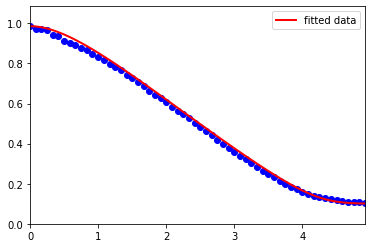

In [9]:
# fit model
result = minimize(residual , params, args=(t_measured, s_measured), method='leastsq')  # leastsq nelder
# check results of the fit
w0 = params['v0'].value, params['s0'].value
data_fitted = g(t_measured, w0, result.params)

# plot fitted data
plt.plot(t_measured, data_fitted[:, 1]+params['b'].value, '-', linewidth=2, color='red', label='fitted data')
#plt.plot(t_measured, data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
plt.legend()
plt.xlim([0, max(t_measured)])
plt.ylim([0, 1.1 * max(data_fitted[:, 1]+params['b'].value)])
# display fitted statistics
report_fit(result)

plt.scatter(t_measured, s_measured, marker='o', color='b', label='measured substrate')
plt.show()

In [10]:
# For DeBug uncomment:
#data_fitted